In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

data_path = '../data/cifar-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ]))
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ]))

label_map = { 0: 0, 2: 1 }
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
conv, conv.weight.shape, conv.bias.shape # weight are 16 * 3 * (3*3)

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


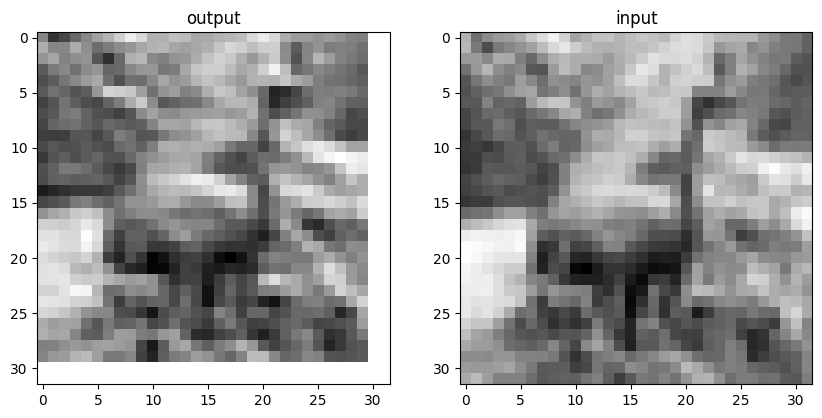

In [14]:
# apply convolution to a single image (for fun)
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # unsqueeze add a dimension to transform the image C*H*W into a batch of 1 images N*C*H*W with N=1

print(img.unsqueeze(0).shape, output.shape) # 16 kernel of 30*30 => not 32*32, we can set padding flag on kernel to avoid this

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [15]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # padding image with 1 pixel with value zero all around
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape) # 16 kernel of 32*32

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32])


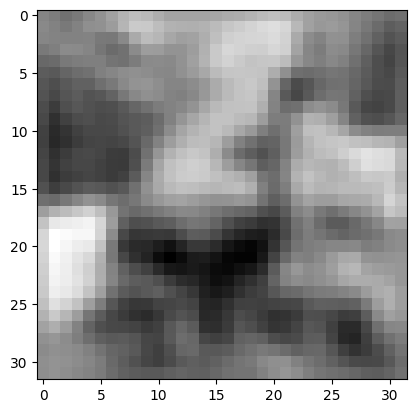

In [17]:
# try a convolution with a smoothing filter
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # padding image with 1 pixel with value zero all around
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0/9.0)
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

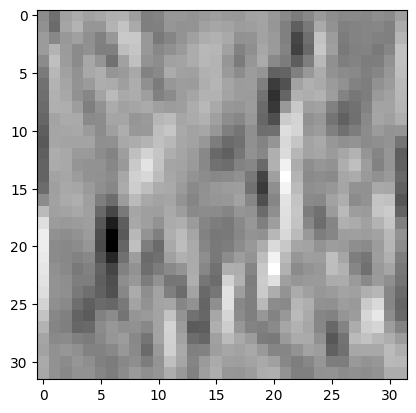

In [18]:
# try a convolution to find vertical edges
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # padding image with 1 pixel with value zero all around
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [20]:
# downsampling image with maxpool
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [21]:
# a model using convolution
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, 3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # missing reshape output of maxpool that is a 8 channels 8x8 image into a one dimension array of 8x8x8=512 items
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True] # list of learning parameters of the model
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [22]:
# create a subclass of module that contains the whole network and the reshape step
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True] # list of learning parameters of the model
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [29]:
# our Net class need to declare all submodules as first level parameter (conv1, act1...) in order to PyTorch to identify them
# we can avoid to declare submodules that have no parameters so PyTorch do not need to keep track of them and use their functional counterpart
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True] # list of learning parameters of the model
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [31]:
# test the model
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0997,  0.0455]], grad_fn=<AddmmBackward0>)

In [32]:
from datetime import datetime as dt

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print(f'{dt.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100,
              optimizer=optimizer,
              model=model,
              loss_fn=loss_fn,
              train_loader=train_loader)

2022-10-26 23:03:07.461067 Epoch 1, Training loss 0.6063526551814595
2022-10-26 23:03:33.855956 Epoch 10, Training loss 0.3429826263599335
2022-10-26 23:04:01.340085 Epoch 20, Training loss 0.2997961556835539
2022-10-26 23:04:28.380954 Epoch 30, Training loss 0.2669758417993594
2022-10-26 23:04:56.625151 Epoch 40, Training loss 0.24509459658033528
2022-10-26 23:05:24.585709 Epoch 50, Training loss 0.2298086579817875
2022-10-26 23:05:53.499604 Epoch 60, Training loss 0.2161711190773803
2022-10-26 23:06:22.149855 Epoch 70, Training loss 0.2014582858059057
2022-10-26 23:06:53.315365 Epoch 80, Training loss 0.1893230830882765
2022-10-26 23:07:23.005629 Epoch 90, Training loss 0.1758856492911934
2022-10-26 23:07:51.337921 Epoch 100, Training loss 0.16236042532666473


In [34]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=-1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print(f'Accuracy {name} = {correct/total} ({correct}/{total})')

validate(model, train_loader, val_loader)

Accuracy train = 0.9309 (9309/10000)
Accuracy val = 0.877 (1754/2000)


In [38]:
# save the model so far with all weights and bias (no structure)
torch.save(model.state_dict(), '../models/birds_vs_airplane.pt')

In [40]:
# reload the model
model = Net()
model.load_state_dict(torch.load('../models/birds_vs_airplane.pt'))

<All keys matched successfully>

In [41]:
# use GPU when available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Training on device {device}')

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs.to(device=device)   # add this
            labels.to(device=device) # add this
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print(f'{dt.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}')

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device) # add this
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100,
              optimizer=optimizer,
              model=model,
              loss_fn=loss_fn,
              train_loader=train_loader)

Training on device cpu
2022-10-26 23:18:46.917968 Epoch 1, Training loss 0.5764217815201753


KeyboardInterrupt: 

In [42]:
# model load will try to allocate resources on same device as they were when saved, we can override this behaviour and load them where we want:
model = Net()
model.load_state_dict(torch.load('../models/birds_vs_airplane.pt', map_location=device))

<All keys matched successfully>